In [2]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import os
from google.colab import files
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


In [5]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.ToTensor(),
])


class FER2013Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.squeeze()
        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)
        image = np.transpose(image, (1, 2, 0))
        if self.transform:
            image = self.transform(image)
        return image, label



def load_data(csv_file):
    df = pd.read_csv(csv_file)
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    df = df[df['pixels'].apply(len) == 2304]
    X = np.array(df['pixels'].tolist(), dtype=np.float32).reshape(-1, 48, 48)
    X = np.expand_dims(X, 1)
    y = df['emotion'].values

    emotion_counts = df['emotion'].value_counts()
    emotion_counts = emotion_counts.sort_index()

    emotion_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    bar_colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink']

    plt.figure(figsize=(10, 5))
    bars = plt.bar(emotion_names, emotion_counts[emotion_counts.index], color=bar_colors)


    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10, rotation=0)

    plt.xlabel('Emotions')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion')
    plt.xticks(rotation=45)
    plt.show()


    return X, y

def create_dataloaders(X, y, batch_size=512):
    # split the data into training+validation and testing sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 20% of 80% = 16% of total data

    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create datasets
    train_dataset = FER2013Dataset(X_train, y_train, transform=train_transform)
    val_dataset = FER2013Dataset(X_val, y_val, transform=train_transform)
    test_dataset = FER2013Dataset(X_test, y_test, transform=train_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



In [7]:
class Network(nn.Module):
    def __init__(self, num_classes=7):  # 7 emotion classes for FER2013
        super(Network, self).__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(0.25)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(0.25)
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(0.25)
        )

        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(0.5)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x



def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    # history lists to keep track of loss and accuracy
    trn_loss_hist = []
    val_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []

    model.train()

    for epoch in range(num_epochs):
        running_loss = []
        running_val_loss = []
        print(f'----------------- Epoch = {epoch+1} -----------------')

        # training loop
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())

        epoch_loss = np.mean(running_loss)
        trn_loss_hist.append(epoch_loss)

        # validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss.append(val_loss.item())

        epoch_val_loss = np.mean(running_val_loss)
        val_loss_hist.append(epoch_val_loss)
        model.train()

        # evaluate accuracy
        train_accuracy = evaluate(model, train_loader, device)
        val_accuracy = evaluate(model, val_loader, device)
        trn_acc_hist.append(train_accuracy)
        val_acc_hist.append(val_accuracy)

        print(f"Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

    return trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


Index(['emotion', 'pixels', 'Usage'], dtype='object')


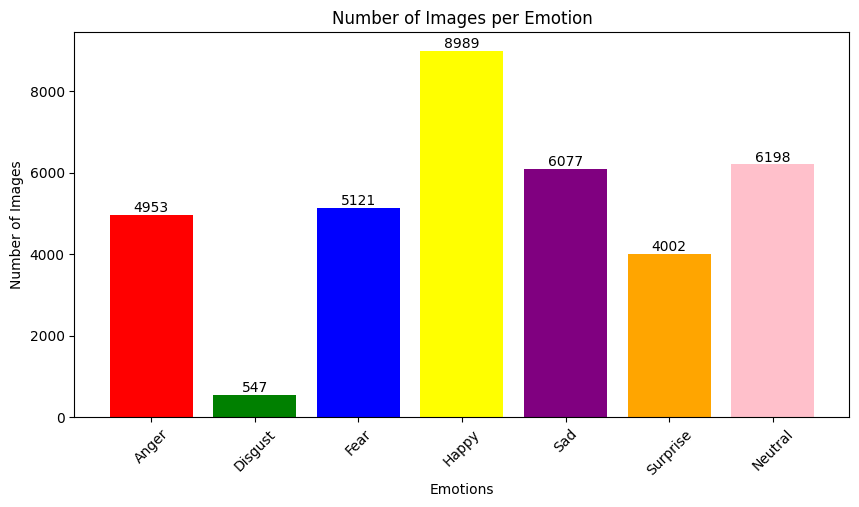

In [9]:
# main
csv_file = 'fer2013.csv'
df = pd.read_csv(csv_file)
print(df.columns)
X,y = load_data(csv_file)
train_loader, val_loader, test_loader = create_dataloaders(X, y)



In [ ]:
model = Network().to(device)
criterion = nn.CrossEntropyLoss()


num_epochs = 200
learning_rate = 1e-4
weight_decay = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# evaluate on test set
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
print(model)

x = np.arange(num_epochs)

plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(range(0, num_epochs, 10))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fer2013 Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(trn_loss_hist, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




In [49]:

torch.save(model, 'complete_model.pth')
files.download('complete_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>